## Intro to dataset
### https://www.kaggle.com/uciml/pima-indians-diabetes-database
#### 1. Number of times pregnant
#### 2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
#### 3. Diastolic blood pressure (mm Hg)
#### 4. Triceps skin fold thickness (mm)
#### 5. 2-Hour serum insulin (mu U/ml)
#### 6. Body mass index (weight in kg/(height in m)^2)
#### 7. Diabetes pedigree function
#### 8. Age (years)
#### 9. Class variable (0 or 1)

#### Problem Statement: Given a set of eight medical characteristics about a patients, predict whether or not the patient has diabetes. To accomplish this task, we will use a set of real-world data collected on females 21 years of age and over collected by a national health institution in the United States.

In [20]:
! pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=2bf7202d95daf90fbfbafb2428b093c80f592ca2e7e258a70f58819054a7d077
  Stored in directory: C:\Users\sidha\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from pymc3 import *
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import theano


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sidha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [22]:
from IPython.core.pylabtools import figsize
import matplotlib.lines as mlines

import seaborn as sns

# Standard machine learning models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve

import itertools

pd.options.mode.chained_assignment = None

import matplotlib as mpl

from warnings import filterwarnings
filterwarnings('ignore')

In [21]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

In [8]:
data = pd.read_csv(r'diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Missing Values
#### There are missing values which are represented by 0 and are not possible. Repalcing the missing values of each column with the median values

In [15]:
data['Glucose'] = data['Glucose'].replace({0: data['Glucose'].median()})
data['BloodPressure'] = data['BloodPressure'].replace({0: data['BloodPressure'].median()})
data['SkinThickness'] = data['SkinThickness'].replace({0: data['SkinThickness'].median()})
data['Insulin'] = data['Insulin'].replace({0: data['Insulin'].median()})
data['BMI'] = data['BMI'].replace({0: data['BMI'].median()})


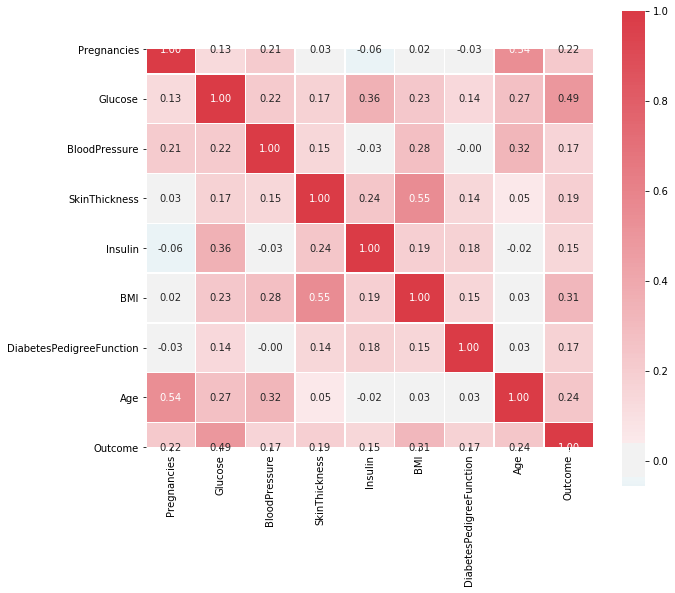

In [30]:
correlations = data.corr()
## Create color map ranging between two colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()


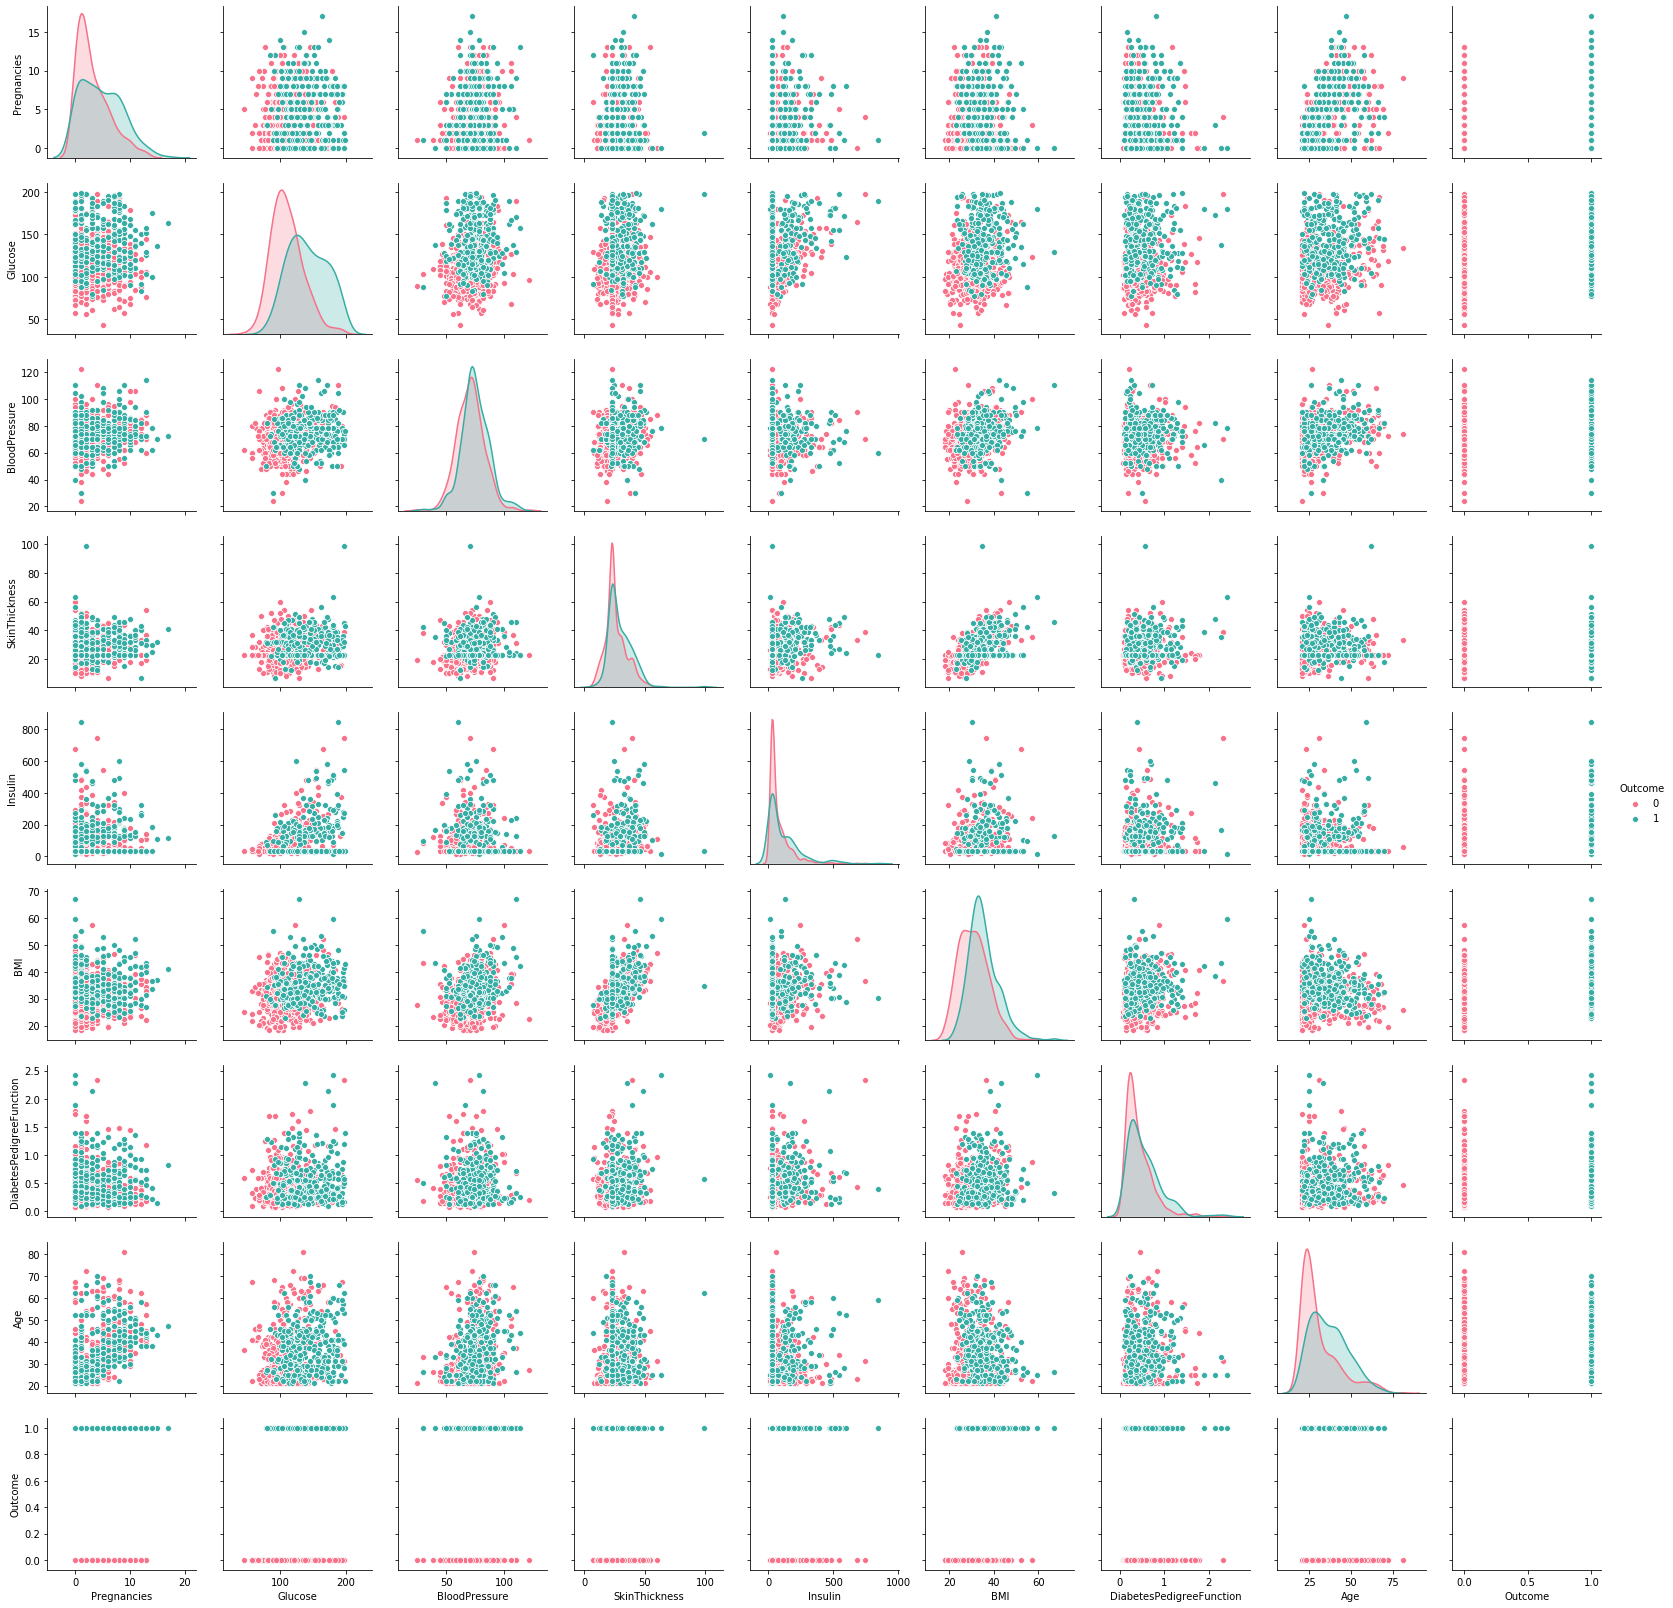

In [18]:
g = sns.pairplot(data, hue="Outcome", palette="husl")

### training and test data

In [23]:
# Extract the features and the labels
features = data.drop(columns='Outcome')
labels = data.Outcome

# Split into training and testing set using 200 observations for testing
X, X_test, y, y_test = train_test_split(features, labels, test_size=200, random_state = 50)

print(X.shape)
print(X_test.shape)

(568, 8)
(200, 8)


In [26]:
# Visualize a confusion matrix as a plot given the confusion matrix
def plot_confusion_matrix(cm, classes = ['No Diabetes', 'Diabetes'],
                          title='Diabetes Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

In [25]:
def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
    print('F1 Score of Model: {:.4f}'.format(f1_metric))

In [28]:
help(LogisticRegressionCV)

Help on class LogisticRegressionCV in module sklearn.linear_model.logistic:

class LogisticRegressionCV(LogisticRegression, sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin)
 |  LogisticRegressionCV(Cs=10, fit_intercept=True, cv='warn', dual=False, penalty='l2', scoring=None, solver='lbfgs', tol=0.0001, max_iter=100, class_weight=None, n_jobs=None, verbose=0, refit=True, intercept_scaling=1.0, multi_class='warn', random_state=None, l1_ratios=None)
 |  
 |  Logistic Regression CV (aka logit, MaxEnt) classifier.
 |  
 |  See glossary entry for :term:`cross-validation estimator`.
 |  
 |  This class implements logistic regression using liblinear, newton-cg, sag
 |  of lbfgs optimizer. The newton-cg, sag and lbfgs solvers support only L2
 |  regularization with primal formulation. The liblinear solver supports both
 |  L1 and L2 regularization, with a dual formulation only for the L2 penalty.
 |  Elastic-Net penalty is only supported by the saga solver.
 |  
 |  

In [ ]:
lr = LogisticRegressionCV(Cs= 20, cv = 3, scoring = 'f1', 
                          penalty = 'l2', random_state = 42)
lr.fit(X, y)